In [1]:
n_threads = 14

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

In [3]:
import torch
if n_threads is not None:
    torch.set_num_threads(n_threads)

In [4]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.means import ConstantMean

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

## Define VOCS

In [5]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL", "QUAD:IN20:122:BCTRL",
             "QUAD:IN20:361:BCTRL", "QUAD:IN20:371:BCTRL", "QUAD:IN20:425:BCTRL",
             "QUAD:IN20:441:BCTRL", "QUAD:IN20:511:BCTRL", "QUAD:IN20:525:BCTRL"]
vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    objectives = {"total_size": "MINIMIZE"},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
  QUAD:IN20:122:BCTRL: [-0.021, 0.021]
  QUAD:IN20:361:BCTRL: [-4.32, -1.08]
  QUAD:IN20:371:BCTRL: [1.09, 4.31]
  QUAD:IN20:425:BCTRL: [-7.56, -1.08]
  QUAD:IN20:441:BCTRL: [-1.08, 7.56]
  QUAD:IN20:511:BCTRL: [-1.08, 7.56]
  QUAD:IN20:525:BCTRL: [-7.56, -1.08]
constraints: {}
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define NN prior

In [6]:
model_path = "lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Define Evaluate Function

In [7]:
# Xopt evaluator function
def evaluate(input_dict):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["OTRS:IN20:571:XRMS"], model_result["OTRS:IN20:571:YRMS"])
    return {vocs.objective_names[0]: sigma_xy.detach().item()}

## Run Xopt

In [8]:
# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": objective_model},
)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

In [9]:
default = {
    "SOLN:IN20:121:BCTRL": 0.4726221999999998,
    "QUAD:IN20:121:BCTRL": -0.0048398437,
    "QUAD:IN20:122:BCTRL": 0.0018000000000000004,
    "QUAD:IN20:361:BCTRL": -3.16,
    "QUAD:IN20:371:BCTRL": 2.5352702,
    "QUAD:IN20:425:BCTRL": -1.5,
    "QUAD:IN20:441:BCTRL": -0.8118599,
    "QUAD:IN20:511:BCTRL": 3.6494056,
    "QUAD:IN20:525:BCTRL": -3.2522187,
}

X.evaluate_data(pd.DataFrame(default, index=[0]))

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,total_size,xopt_runtime,xopt_error
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,344.779441,0.00185,False


In [10]:
env_variable = "OMP_NUM_THREADS"
if env_variable in os.environ.keys():
    print("{}: {}".format(env_variable, os.environ[env_variable]))

print("torch num_threads: {:d}".format(torch.get_num_threads()))

OMP_NUM_THREADS: 14
torch num_threads: 14


In [11]:
%%time
for i in range(50):
    X.step()

CPU times: user 5min 42s, sys: 59.2 s, total: 6min 42s
Wall time: 3min 17s


<Axes: >

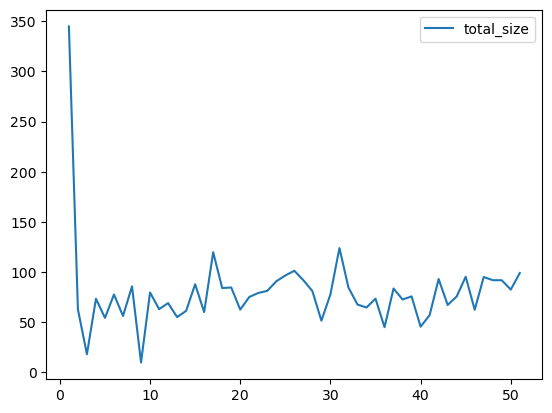

In [12]:
X.data.plot(y="total_size")

In [13]:
for key in X.generator.computation_time.columns:
    mean = X.generator.computation_time[key].mean()
    std = X.generator.computation_time[key].std()
    print("{}: {:.2f} +- {:.2f} sec".format(key, mean, std))

training: 0.04 +- 0.01 sec
acquisition_optimization: 3.90 +- 1.44 sec
